In [19]:
# Sample each set with 12000 train and 5000 test
import pandas as pd

def create_dataset(ratio):
    df = pd.read_csv("./train.txt", delimiter=',')
    fitSet = df[lambda df:df["fit"]=="fit"][["fit", "review_text"]].dropna()
    smallSet = df[lambda df:df["fit"]=="small"][["fit", "review_text"]].dropna()
    largeSet = df[lambda df:df["fit"]=="large"][["fit", "review_text"]].dropna()
    # train
    fitTrain = fitSet.sample(int(len(fitSet.index)*ratio))
    smallTrain = smallSet.sample(int(len(smallSet.index)*ratio))
    largeTrain = largeSet.sample(int(len(largeSet.index)*ratio))
    Train = pd.concat([fitTrain, smallTrain, largeTrain])
    Train.to_csv('./train.csv', index=False)
    # test
    fitTD = list(fitTrain.index)
    fitTest = fitSet.drop(None,0,index=fitTD)
    smallTD = list(smallTrain.index)
    smallTest = smallSet.drop(None,0,index=smallTD)
    largeTD = list(largeTrain.index)
    largeTest = largeSet.drop(None,0,index=largeTD)
    Test = pd.concat([fitTest,smallTest,largeTest])
    Test.to_csv('./test.csv', index=False)
    print(Train)
    
# create_dataset(0.5)
    

          fit                                        review_text
117762    fit  This dress is AMAZING!  It was my backup and i...
84316     fit  To say this dress is form fitting is an unders...
100366    fit  I got complements all night!! I felt like the ...
56191     fit  Fits true to size. Mildly stretchy at the top....
120334    fit  The dress has a nice fit, a little waist rouch...
...       ...                                                ...
120161  large  Love that this top can be dressy or casual! Th...
126571  large  It ran a little large, but I used the hollywoo...
19435   large  I'm 5'9" and I'm wearing 4' heels in this phot...
134555  large  I got a ton of compliments on this skirt! It w...
117123  large  I ordered a 2 and a 4 but the 2 was a little b...

[67476 rows x 2 columns]


Tokenizing: 100%|██████████| 134954/134954 [08:25<00:00, 266.92it/s]


Vocab size: 6662


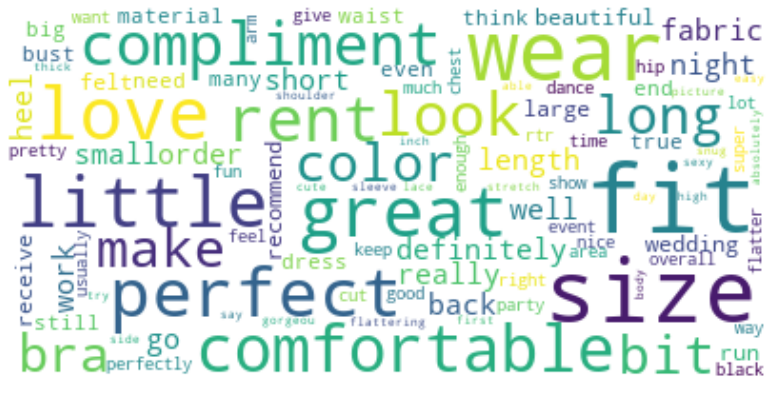

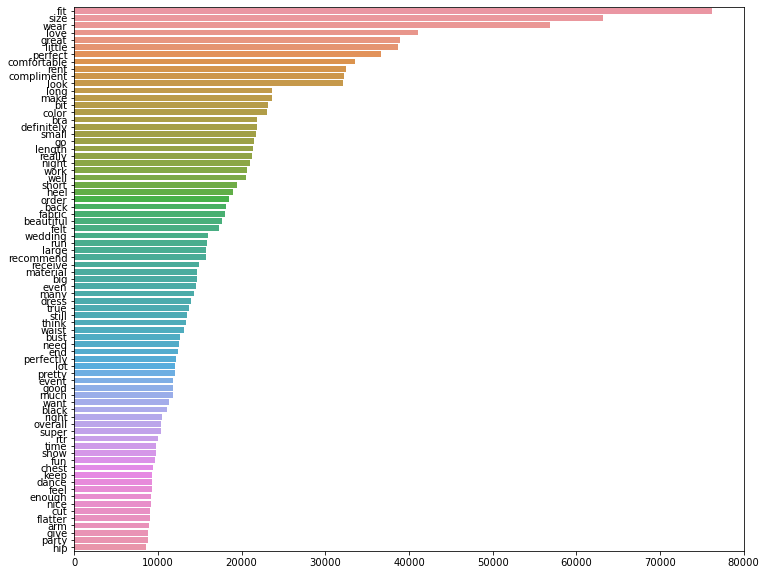

In [15]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from collections import Counter

clothes = pd.read_csv("./train.txt", delimiter=",")["category"].value_counts().index.tolist()


def lemmatize(word, tag):
    wnl = WordNetLemmatizer()
    if tag.startswith("NN"):
        return wnl.lemmatize(word, 'n')
    elif tag.startswith("JJ"):
        return wnl.lemmatize(word, 'a')
    elif tag.startswith("VB"):
        return wnl.lemmatize(word, 'v')
    elif tag.startswith("RB"):
        return wnl.lemmatize(word, 'r')
    else:
        return word

def tokenize(text):
    """
    Detects trigrams in text
    """
    #for each sentence lemmatize and get bigram and trigram
    result = []
    sents = [sent for sent in sent_tokenize(text)]
    for sent in sents:
        words = [word for word in word_tokenize(sent) if (word.isalpha()==1)]
        tagged = pos_tag(words)
        # Remove stop words
        stop = set(stopwords.words('english'))
        # Feature Selection
        relstop = ["above", "below", "up", "down",  "more", "most", "no", "nor","not", "same", "than", "too"]
        stop.difference_update(relstop)
        stop.update(["the", "dress", "wear"])
        stop.update(clothes)
        for word, tag in tagged:
            if (word not in stop) and (tag[:2] in ["NN", "JJ", "VB", "RB"]):
                result.append(lemmatize(word.lower(), tag))
    return result

def create_vocab(limit = 1,plot = False):
    train = pd.read_csv('train.txt')
    reviews = train["review_text"].dropna().tolist()
    corpus = []
    for review in tqdm(reviews, desc="Tokenizing"):
        tokens = tokenize(review)
        corpus.extend(tokens)
    # Create Counter
    counts = Counter(corpus)
    # Create Bag of Words
    bow = {word: count for word, count in counts.items() if count > limit}
    sbow = sorted(bow, key=bow.get, reverse=True)
    print("Vocab size: {}".format(len(sbow)))
    with open('vocab.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(bow, f, 5)
    if plot:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

# create_vocab(5, True)

In [43]:
import numpy as np

def feature_filter(text, feature, sbow=False):
    if not sbow:
        with open('vocab.pickle', 'rb') as f:
            bow = pickle.load(f)
            sbow = sorted(bow, key=bow.get, reverse=True)[0:feature]
    tokens = tokenize(text)
    counts = Counter(tokens)
    x = np.zeros(feature)
    for i in range(0, feature):
        word = sbow[i]
        wc = counts.get(word)
        if wc:
            x[i] = wc
    return x
    

def label_filter(text):
    if text=="fit":
        return 0
    elif text=="small":
        return 1
    elif text=="large":
        return 2
    else:
        raise Exception("Invalid label text: {}".format(text))

def load_data(feature=200, dataset="train", sample=None):
    df = pd.read_csv(dataset+".csv", delimiter=',')
    if sample:
        df = df.sample(sample)
    bow = None
    with open('vocab.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        bow = pickle.load(f)
    sbow = sorted(bow, key=bow.get, reverse=True)[0:feature]
    bow = { word:bow[word] for word in sbow }
    data = df[["fit", "review_text"]].dropna()
    X = np.zeros((len(data.index), feature))
    y = np.zeros(len(data.index))
    idx = 0
    for index, row in tqdm(data.iterrows(), desc="Loading Data..."):
        X[idx] = feature_filter(row["review_text"], feature, sbow)
        y[idx] = label_filter(row["fit"])
        idx = idx + 1
    with open(dataset+".X.pt", 'wb') as f:
        pickle.dump(X, f, 5)
    with open(dataset+".y.pt", 'wb') as f:
        pickle.dump(y, f, 5)
    return X, y


def load_stored(dataset="train"):
    with open(dataset+".X.pt", 'rb') as f:
        X = pickle.load(f)
    with open(dataset+".y.pt", 'rb') as f:
        y = pickle.load(f)
    return X, y

# load_data(200, "train")
# load_data(200, "test")

In [44]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
import shutil

def rlabel_filter(label):
    if label==0:
        return "fit"
    elif label==1:
        return "small"
    elif label==2:
        return "large"
    else:
        raise Exception("Invalid label: {}".format(label))

def predict_test(feature=200):
#     X, y = load_stored("train")
    X, y = load_data(feature, "train")
    clf = ComplementNB()
    clf.fit(X, y)

#     T, y_true = load_stored("test")
    T, y_true = load_data(feature, "test")
    y_pred = clf.predict(T)

    score = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print("feature: ", feature, "acc: ", acc, "f1: ", score)
    df = pd.read_csv("./test.txt", delimiter=',')
    with open('vocab.pickle', 'rb') as f:
        bow = pickle.load(f)
    sbow = sorted(bow, key=bow.get, reverse=True)[0:feature]
    out = []
    for index, row in tqdm(df.iterrows(), desc="predicting test..."):
        if pd.isna(row["review_text"]):
            out.append("fit")
        else:
            x = feature_filter(row["review_text"], feature, sbow)
            out.append(rlabel_filter(clf.predict([x])[0]))
    assert(len(out)==57544)
    
    outdf = pd.DataFrame({'pred': out})
    outdf.to_csv("output_DZ1933026.txt", index=False, header=False)
    
    itrdir = str(feature)+"-"+str(score)
    Path(itrdir).mkdir(parents=True, exist_ok=True)
    
    for file in ["train.X.pt","train.y.pt","test.X.pt","test.y.pt","output_DZ1933026.txt"]:
        shutil.move(file, itrdir+"/"+file)



for i in range(1, 52):
    feature = i*20
    predict_test(feature)
    
predict_test(2020)
predict_test(4000)


Loading Data...: 67476it [04:32, 247.85it/s]
Loading Data...: 67478it [04:24, 255.52it/s]


feature:  20 acc:  0.5821156525089659 f1:  0.4066587771931469


predicting test...: 57544it [04:02, 237.11it/s]
Loading Data...: 67476it [04:36, 244.14it/s]
Loading Data...: 67478it [04:37, 242.79it/s]


feature:  40 acc:  0.678739737395892 f1:  0.5152559760443159


predicting test...: 57544it [04:01, 238.50it/s]
Loading Data...: 67476it [04:27, 252.57it/s]
Loading Data...: 67478it [04:29, 250.83it/s]


feature:  60 acc:  0.7037552980230594 f1:  0.5508248050617507


predicting test...: 57544it [03:59, 240.44it/s]
Loading Data...: 67476it [04:13, 266.59it/s]
Loading Data...: 67478it [04:23, 255.74it/s]


feature:  80 acc:  0.7038738551824298 f1:  0.5537262909672546


predicting test...: 57544it [03:51, 248.53it/s]
Loading Data...: 67476it [04:32, 247.67it/s]
Loading Data...: 67478it [04:37, 243.12it/s]


feature:  100 acc:  0.7043777231097543 f1:  0.5557230329516174


predicting test...: 57544it [03:57, 242.14it/s]
Loading Data...: 67476it [04:36, 244.22it/s]
Loading Data...: 67478it [04:32, 247.70it/s]


feature:  120 acc:  0.7063339162393669 f1:  0.5626999013258548


predicting test...: 57544it [03:56, 243.75it/s]
Loading Data...: 67476it [04:28, 251.05it/s]
Loading Data...: 67478it [04:28, 251.35it/s]


feature:  140 acc:  0.7080826343400812 f1:  0.5646189215137172


predicting test...: 57544it [03:59, 240.09it/s]
Loading Data...: 67476it [04:50, 232.43it/s]
Loading Data...: 67478it [04:24, 255.07it/s]


feature:  160 acc:  0.7083790272385073 f1:  0.5673944120740076


predicting test...: 57544it [04:07, 232.86it/s]
Loading Data...: 67476it [04:29, 250.09it/s]
Loading Data...: 67478it [04:33, 246.77it/s]


feature:  180 acc:  0.7092089273541006 f1:  0.568876006574259


predicting test...: 57544it [04:04, 235.29it/s]


In [51]:
def example_train():
    create_dataset(0.5)
    create_vocab(5, True)
    predict_test(200)

def example_review():
    X, y = load_stored("200-0.5698526222237081/train")
    clf = ComplementNB()
    clf.fit(X, y)

    T, y_true = load_stored("200-0.5698526222237081/test")
    y_pred = clf.predict(T)

    score = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print("feature: ", 200, "acc: ", acc, "f1: ", score)